In [6]:
import os
import geopandas as gp
import pandas as pd
from shapely.geometry import Point

In [14]:
stations = pd.read_csv("../data/stations.csv")

In [15]:
stations['geometry'] = stations.apply(lambda z: Point(z.LONGITUDE, z.LATITUDE), axis=1)
gdf = gp.GeoDataFrame(stations)

In [19]:
gdf.to_file("../shape/casgem_wells.shp")

In [ ]:
# GLDAS 

In [13]:
import os
import ee
import datetime
import time
import sklearn

import geopandas as gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from dateutil.relativedelta import relativedelta
from sklearn import preprocessing

ee.Initialize()

In [134]:
data = {}
# https://developers.google.com/earth-engine/datasets/catalog/NASA_GLDAS_V020_NOAH_G025_T3H
# The Evaporation rate is instantaneous (i.e. W/km^2/second). There are 86400 seconds in a day, 30 days in a month. A GLDAS month yields 240 images at 3-hourly temporal model resolution 
data['gldas'] = [ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H'), 'Evap_tavg', 86400*30 / 240] 

# https://developers.google.com/earth-engine/datasets/catalog/NASA_NLDAS_FORA0125_H002
data['nldas'] = [ee.ImageCollection('NASA/NLDAS/FORA0125_H002'), 'potential_evaporation', 1]

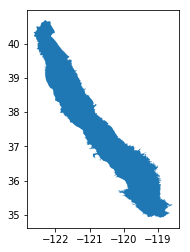

In [109]:
'''
Set the init params:
1) Area: Read from Shapefile
2) Years to analyze: Supplied
3) Scale (optional): Resolution at which to perform analysis
4) Satellites / datasets: Queried from Earth Engine
'''

##### AREA #####

# HUC 4s draining to the CV 
cv = gp.read_file("../shape/cv.shp")
cv2 = cv.geometry.simplify(0.1)
lls = cv2.geometry.iloc[0]
x,y = lls.exterior.coords.xy
coords = [list(zip(x,y))]
area = ee.Geometry.Polygon(coords)
sa_km3 = round(cv2.area[0] * 10000, 2)
        
##### TIME RANGE #####
years = [x for x in range(2001, 2018)]
months = range(1,13)

##### SCALE #####
cv.plot()

In [110]:
years = range(2001, 2019)
months = range(1,13)
start = datetime.datetime(years[0], 1, 1)
end = datetime.datetime(years[-1]+1, 1, 1)
dt_idx = pd.date_range(start,end, freq='M')

In [135]:

def gen_polys(geometry, dx=0.25, dy=0.25):
    
    '''
    Return ee.ImaceCollection of polygons used to submit full res queries
    '''
    
    bounds = ee.Geometry(geometry).bounds()
    coords = ee.List(bounds.coordinates().get(0))
    ll = ee.List(coords.get(0))
    ur = ee.List(coords.get(2))
    xmin = ll.get(0)
    xmax = ur.get(0)
    ymin = ll.get(1)
    ymax = ur.get(1)

    latlist = ee.List.sequence(ymin, ymax, dx)
    lonlist = ee.List.sequence(xmin, xmax, dy)
    
    polys = []
    
    for lon in lonlist.getInfo():
        for lat in latlist.getInfo():
        
            def make_rect(lat, lon):
                lattemp = ee.Number(lat)
                lontemp = ee.Number(lon)
                uplattemp = lattemp.add(dy)
                lowlontemp = lontemp.add(dx)

                return ee.Feature(ee.Geometry.Polygon([[lontemp, lattemp],[lowlontemp, lattemp],[lowlontemp, uplattemp],[lontemp, uplattemp]]))
            
            poly = make_rect(lat,lon)
            polys.append(poly)
    
    return ee.FeatureCollection(ee.List(polys))


In [112]:
col = data['gldas'][0]
var = data['gldas'][1]
var_name = data['gldas'][1]
scaling_factor = data['gldas'][2]

year = years[0]
month = months[0]
day = 1


# t = col.filter(ee.Filter.calendarRange(year, year, 'year')).filter(ee.Filter.calendarRange(month, month, 'month')).filter(ee.Filter.calendarRange(day,day,"DAY_OF_MONTH")).sum()
# t2 = t.select(var).filterBounds(area).sum()
# t3 = t2.multiply(1e-3).multiply(ee.Image.pixelArea()).multiply(scaling_factor).multiply(1e-9)

In [136]:
def calc_monthly_sum(ImageCollection, var, dates):
    
    '''
    Calculates monthly sum for hourly data. works for GLDAS / NLDAS 
    '''
        
    sums = []
    seq = ee.List.sequence(0, len(dates))
    
    scaling_factor = 86400*30 / 240 # The Evaporation rate is instantaneous (i.e.) per second. There are 86400 seconds in a day, 30 days in a month. 240 images at 3-hourly temporal model resolution  per month. 
    
    for i in seq.getInfo():
        print(i)
        start = ee.Date('2001-01-01').advance(i, 'month')
        end = start.advance(1, 'month');
        im = ee.ImageCollection(ImageCollection).select(var).filterDate(start, end).sum().set('system:time_start', start.millis())
        ic = im.multiply(1e-3).multiply(ee.Image.pixelArea()).multiply(scaling_factor).multiply(1e-9)
        scale = ic.projection().nominalScale()
        
        sumdict  = ic.reduceRegion(
            reducer = ee.Reducer.sum(),
            geometry = area,
            scale = scale)
        total = sumdict.getInfo()[var]
        print(total)
        sums.append(total)

    return sums

In [115]:
t = calc_monthly_sum(col, "Evap_tavg", dt_idx)

0.0
6.988933689359079
1.0
10.808811307640688
2.0
25.521566064479615
3.0
30.685586623589213
4.0
35.70525430265257
5.0
20.863226023628897
6.0
12.127418382134797
7.0
5.976838310577031
8.0
3.8826119688494716
9.0
3.554444601435584
10.0
5.787722793947797
11.0
5.029014349940271
12.0
7.698225337958348
13.0
13.351804818277344
14.0
24.824256049766312
15.0
28.88705514624515
16.0
28.821634873956942
17.0
21.923919674912952
18.0
11.74057469738057
19.0
5.507787042805679
20.0
2.598423546660079
21.0
1.2789499809165716
22.0
7.510071834466757
23.0
7.581155506919132
24.0
9.787751301725056
25.0
14.589630778148896
26.0
28.337182598338508
27.0
28.783744344408785
28.0
38.714047610288354
29.0
29.081097249717978
30.0
17.419990880312096
31.0
11.225356986966892
32.0
5.079565181803074
33.0
2.3112188976636925
34.0
3.751274746384527
35.0
5.989079598621976
36.0
7.856105979790769
37.0
11.417647961792099
38.0
32.04786310614284
39.0
33.44068101665468
40.0
25.34523996952143
41.0
16.97294456716414
42.0
9.79128226526305
43

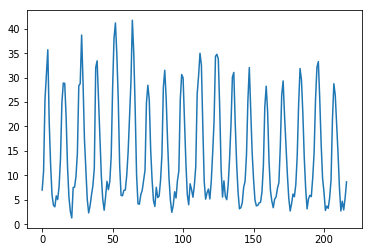

In [116]:
plt.plot(t)

In [123]:

# t2 = t.multiply(1e-3).multiply(ee.Image.pixelArea()).multiply(86400*30).multiply(1e-9)
# # convert mm to m, multiply by pixel area (m^2), multiply by scaling factor, m^3 to km^3
# scale = t2.projection().nominalScale()
# sumdict  = t2.reduceRegion(
#     reducer = ee.Reducer.sum(),
#     geometry = area,
#     scale = scale)

# result = sumdict.getInfo()[var]

AttributeError: 'list' object has no attribute 'multiply'

In [ ]:
t2 = calc_monthly_sum(col, "Evap_tavg", dt_idx)

0.0
0.8736167111698849
1.0
1.351101413455086
2.0
3.190195758059952
3.0
3.8356983279486516
4.0
4.463156787831571
5.0
2.607903252953612
6.0
1.5159272977668496
7.0
0.7471047888221288
8.0
0.48532649610618395
9.0
0.444305575179448
10.0
0.7234653492434746
11.0
0.6286267937425338
12.0
0.9622781672447935
13.0
1.668975602284668
14.0
3.103032006220789
15.0
3.6108818932806437
16.0
3.6027043592446177
17.0
2.740489959364119
18.0
1.4675718371725712
19.0
0.6884733803507099
20.0
0.32480294333250986
21.0
0.15986874761457145
22.0
0.9387589793083446
23.0
0.9476444383648915
24.0
1.223468912715632
25.0
1.823703847268612
26.0
3.5421478247923135
27.0
3.597968043051098
28.0
4.839255951286044
29.0
3.635137156214747
30.0
2.177498860039012
31.0
1.4031696233708615
32.0
0.6349456477253842
33.0
0.28890236220796156
34.0
0.4689093432980659
35.0
0.748634949827747
36.0
0.9820132474738461
37.0
1.4272059952240124
38.0
4.005982888267855
39.0
4.180085127081835
40.0
3.1681549961901787
41.0
2.1216180708955177
42.0
1.22391028

In [ ]:

asdf